In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors 
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import KFold 
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from lightgbm import LGBMClassifier
import warnings, gc, string, random
import plotly.figure_factory as ff

warnings.filterwarnings('ignore')
color = px.colors.qualitative.Plotly 
init_notebook_mode(connected=True)
temp = dict(layout=go.Layout(font=dict(family='Franklin Gothic', size=12), 
                             height=500, width=1000))
pd.set_option('display.max_row', None)
pd.set_option('display.max_column', None)

In [2]:
train_df = pd.read_csv('../tps-may-2022/train.csv', index_col='id')
test_df = pd.read_csv('../tps-may-2022/test.csv', index_col='id')

print(f'Training Shape: ther are {train_df.shape[0]} rows and {train_df.shape[1]} columns. \n'
      f'Missing values = {train_df.isnull().sum().sum()}, duplicates = {train_df.duplicated().sum()}. \n')

print(f'Testing Shape: ther are {test_df.shape[0]} rows and {test_df.shape[1]} columns. \n'
      f'Missing values = {test_df.isnull().sum().sum()}, duplicates = {test_df.duplicated().sum()}. \n')

df = train_df.describe().T
display(df.style.format('{:,.3f}').background_gradient(subset=(df.index[:], df.columns[1:]), cmap='GnBu'))

Training Shape: ther are 900000 rows and 32 columns. 
Missing values = 0, duplicates = 0. 

Testing Shape: ther are 700000 rows and 31 columns. 
Missing values = 0, duplicates = 0. 



,count,mean,std,min,25%,50%,75%,max
f_00,"900,000.000",-0.000,0.999,-4.600,-0.675,0.001,0.674,4.749
f_01,"900,000.000",0.001,0.999,-4.682,-0.675,0.002,0.675,4.816
f_02,"900,000.000",0.001,1.001,-4.643,-0.674,0.002,0.678,4.962
f_03,"900,000.000",-0.001,1.000,-4.659,-0.676,-0.002,0.673,4.455
f_04,"900,000.000",-0.001,1.000,-4.749,-0.676,-0.002,0.674,4.949
f_05,"900,000.000",0.000,1.000,-4.750,-0.673,-0.000,0.675,4.972
f_06,"900,000.000",-0.001,1.000,-4.843,-0.675,-0.001,0.675,4.823
f_07,"900,000.000",2.031,1.656,0.000,1.000,2.000,3.000,15.000
f_08,"900,000.000",2.058,1.591,0.000,1.000,2.000,3.000,16.000
f_09,"900,000.000",2.362,1.638,0.000,1.000,2.000,3.000,14.000


In [3]:
target = train_df.target.value_counts(normalize=True)[::-1]
text = [f'State {i}' for i in target.index]
color, pal = ['#38A6A5', '#E1B580'], ['#88CAC9', '#EDD3B3']

color, pal = (color, pal) if text[0] == 'State 0' else (color[::-1], pal[::-1])

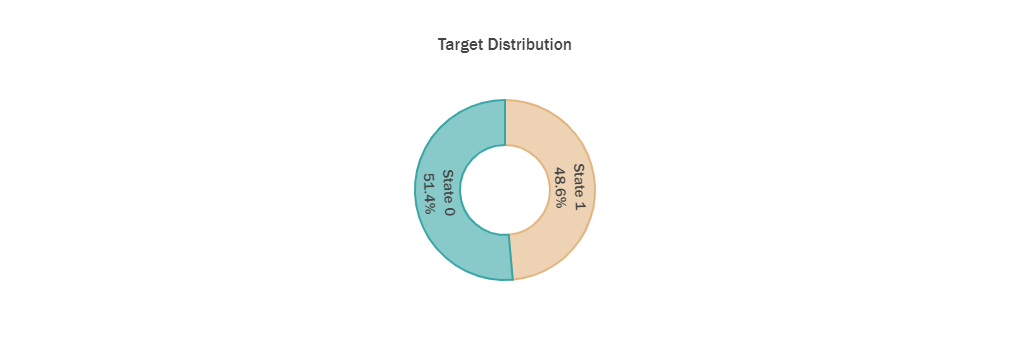

In [4]:
fig = go.Figure()
fig.add_trace(go.Pie(labels=target.index, values=target*100, hole=.5, 
                     text=text, sort=False, showlegend=False, 
                     marker=dict(colors=pal, line=dict(color=color, width=2)), 
                     hovertemplate='State %{label}: %{value:.2f}%<extra></extra>'))

fig.update_layout(template=temp, title='Target Distribution', 
                  uniformtext_minsize=15, uniformtext_mode='hide', width=700)
fig.show()

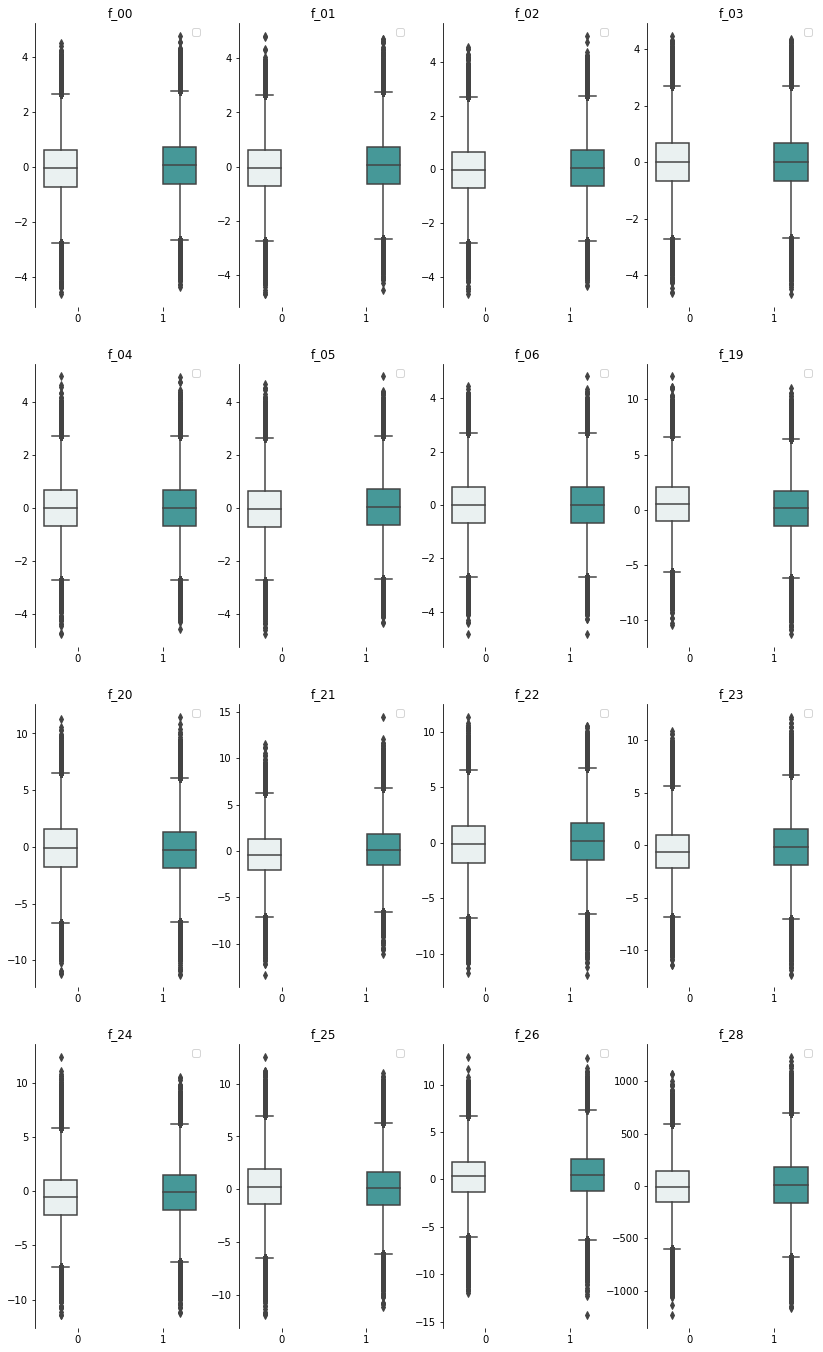

In [5]:
float_cols = train_df.select_dtypes('float')

df = pd.concat([float_cols, train_df['target']], axis=1)

titles = [f"Feature {i.split('_')[-1]}" for i in df.columns[:-1]]
fig, axes = plt.subplots(4, 4, figsize=(14, 24))
axes = axes.flatten() 

COLOR = '#38A6A5'
for i, col in enumerate(df.columns[:-1]):
    rgb = matplotlib.colors.to_rgba(COLOR, 0.2)
    sns.boxplot(y=df[col], x=df.target, ax=axes[i], color=rgb, 
                hue=df.target)
    axes[i].set_title(col) 
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].legend('')
    axes[i].spines[['top', 'right', 'bottom']].set_visible(False)

In [6]:
float_cols = pd.concat([float_cols, train_df.target], axis=1)

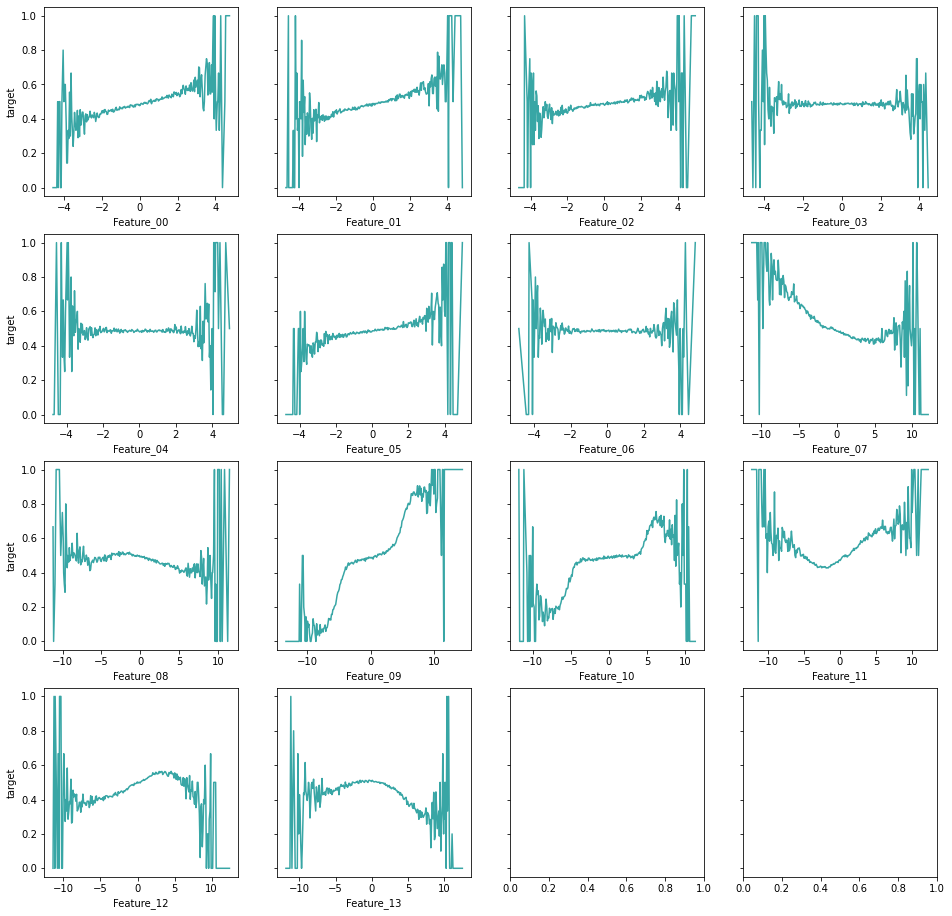

In [7]:
fig, axes = plt.subplots(4, 4, sharey=True, figsize=(16, 16))
axes = axes.flatten()

for i, col in enumerate(float_cols.columns[:-3]):
    float_cols['bins'] = pd.cut(float_cols[col], 250)
    float_cols['mean'] = float_cols.bins.apply(lambda x: x.mid)
    df = float_cols.groupby('mean')[col, 'target'].transform('mean')
    df = df.drop_duplicates(subset=[col])
    sns.lineplot(x=df[col], y=df['target'], ax=axes[i], color=COLOR)
    axes[i].set_xlabel(f'Feature_{i:02d}')

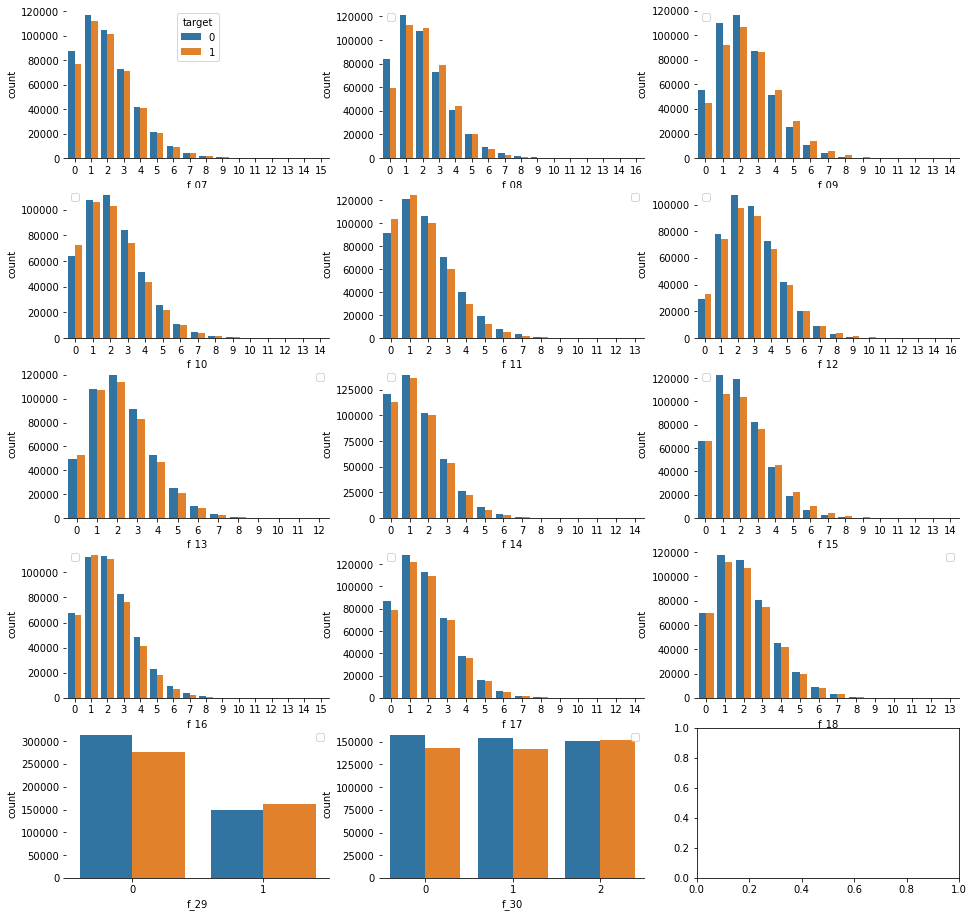

In [8]:
int_df = train_df.select_dtypes('int')
sub_titles = [f"Feature {i.split('_')[-1]}" for i in int_df.columns[:-1]]

fig, axes = plt.subplots(5, 3, figsize=(16, 16))
axes = axes.flatten()
for i, col in enumerate(int_df.columns[:-1]):
    df = int_df.groupby(col)['target'].value_counts().rename('count').reset_index()
    sns.barplot(x=df[col], y=df['count'], hue=df['target'], ax=axes[i], )
    axes[i].spines[['left', 'top', 'right']].set_visible(False)
    if i != 0:
        axes[i].legend('')

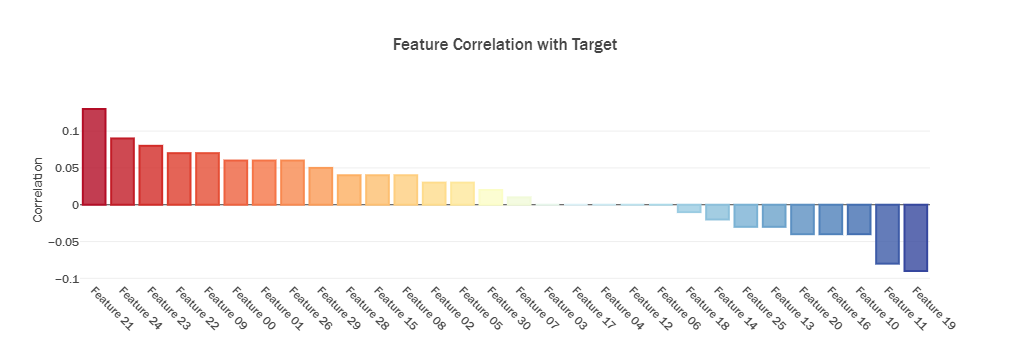

In [9]:
corr = train_df.corr().round(2)
corr = corr.iloc[:-1, -1].sort_values(ascending=False)
titles = [f"Feature {i.split('_')[1]}" for i in corr.index]
corr.index = titles
pal = sns.color_palette('RdYlBu', 32).as_hex()
pal = [j for i, j in enumerate(pal) if i not in (14, 15)]
rgb = ["rgba"+str(matplotlib.colors.to_rgba(i, 0.8)) for i in pal] 
fig = go.Figure()
fig.add_trace(go.Bar(x=corr.index, y=corr, marker_color=rgb, 
                     marker_line=dict(color=pal, width=2), 
                     hovertemplate='%{x} correlation with Target = %{y}', 
                     showlegend=False, name=''))
fig.update_layout(template=temp, title='Feature Correlation with Target', 
                  yaxis_title='Correlation', xaxis_tickangle=45, width=800)
fig.show()

<AxesSubplot:>

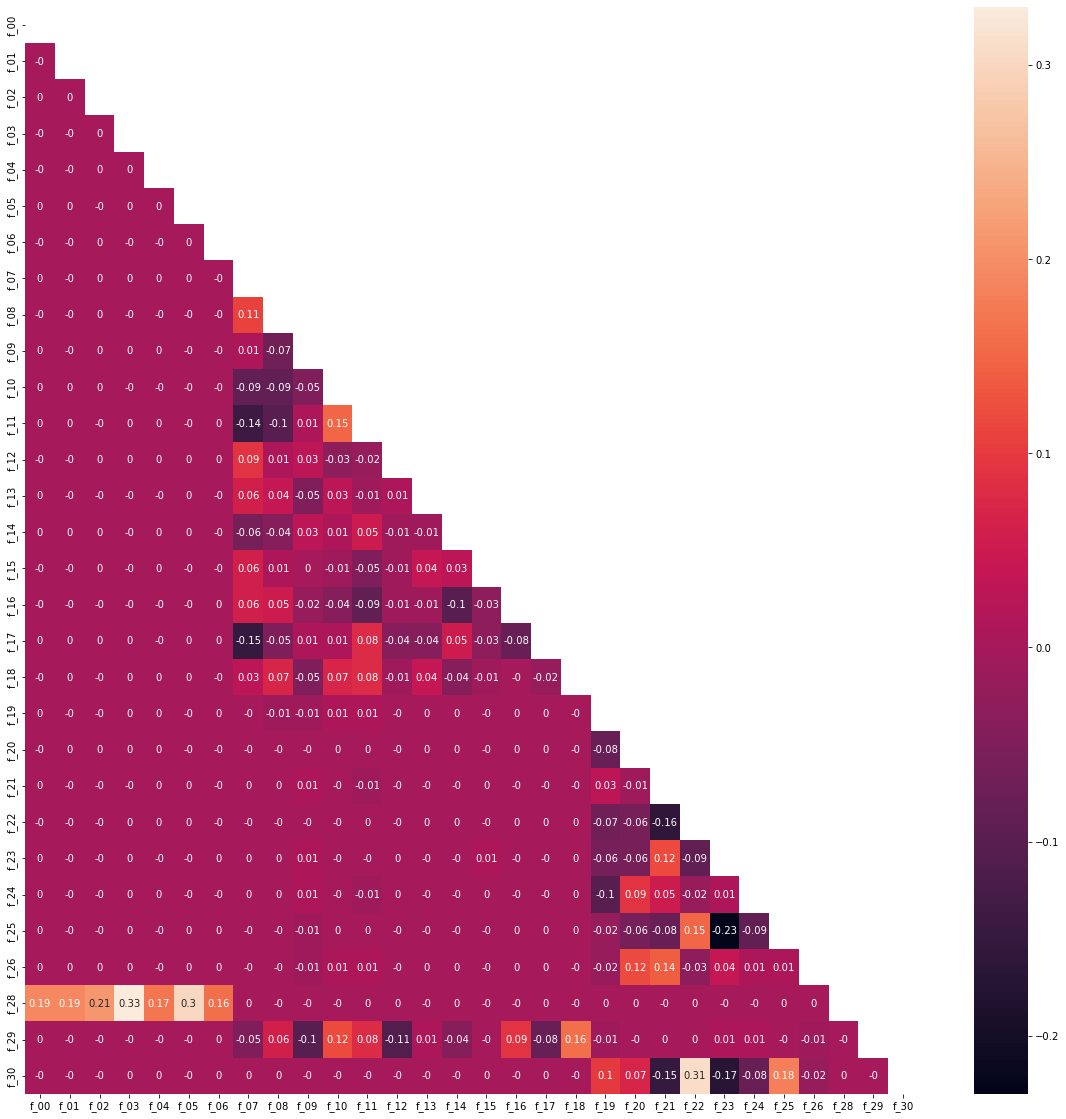

In [16]:
corr = train_df.iloc[:, :-1].corr().round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(20, 20))
sns.heatmap(data=corr, mask=mask, annot=True)